# House Price Prediction - Keras, PyTorch, and JAX

This notebook does the following:
1. **Loads** and **preprocesses** data (fills missing values, log-transforms SalePrice).
2. **Selects the top 3 features** by correlation and **adds a random interaction feature**.
3. **Trains** three neural networks (Keras, PyTorch, JAX) with a combined MSE + KL divergence loss.
4. **Plots separate** loss curves and histograms for each framework.
5. **Saves** test predictions to CSV.

**Note**: We set `alpha = 0.001` for the KL term in all three frameworks, which previously worked well for Keras.


## Math Overview: MSE + KL

- **MSE**: \(\text{mean}((y_{true} - y_{pred})^2)\) on log(SalePrice).
- **KL Divergence**: Compare the soft histograms of \(y_{true}\) and \(y_{pred}\) using
  \(\sum P_j \log(P_j / Q_j)\), with a small epsilon to avoid log(0).
- **Combined Loss**: \(\text{MSE} + \alpha \times D_{KL}\). Here, \(\alpha=0.001\).

In [1]:
pip install tensorflow pytorch jax flax

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-tu99rigw/pytorch_ea8aa66fd5c9468bbf6bf7ac8873ddfe/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable whe

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# JAX / Flax / Optax
import jax
import jax.numpy as jnp
import flax.linen as nn_flax
from flax.training import train_state
import optax

print('TensorFlow version:', tf.__version__)
print('Torch version:', torch.__version__)
print('JAX version:', jax.__version__)

%matplotlib inline

2025-02-25 11:03:27.237672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 11:03:27.447271: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 11:03:27.619701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740481407.926280    6843 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740481407.995227    6843 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 11:03:28.642456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

TensorFlow version: 2.18.0
Torch version: 2.5.1+cpu
JAX version: 0.5.0


## 1. Load and Preprocess Data

**We fill missing values** in both train and test to avoid NaNs. **We log-transform** the SalePrice in train.

In [3]:
# Update these paths
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

def fill_missing_values(df):
    num_cols = df.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Fill missing values in train
train_df = fill_missing_values(train_df.copy())

# Log-transform SalePrice
y = np.log(train_df['SalePrice'])
X = train_df.drop(['Id','SalePrice'], axis=1)

# One-hot encode
X = pd.get_dummies(X, drop_first=True)
print('Initial X shape:', X.shape)


Train shape: (1000, 81)
Test shape: (460, 80)
Initial X shape: (1000, 230)


/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

### 1.1 Select Top 3 Features + Random Interaction

In [4]:
# Correlation with SalePrice
temp_df = train_df.select_dtypes(include=[np.number])
corr_matrix = temp_df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:4].index.tolist()
print('Top 3 features:', top_features)

# Restrict X to these
X = X[top_features]
print('X shape after top-3 selection:', X.shape)

# Random interaction feature
#if len(top_features) >= 2:
#    f1, f2 = top_features[0], top_features[1]
#    X['RandomInteraction'] = X[f1] * X[f2]
#    print('Added RandomInteraction feature:', f1, '*', f2)
#    print('New X shape:', X.shape)


Top 3 features: ['OverallQual', 'GrLivArea', 'GarageCars']
X shape after top-3 selection: (1000, 3)


### 1.2 Train-Validation Split and Scaling

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 3)
X_val_scaled shape: (200, 3)


## 2. Keras/TensorFlow
Two hidden layers (128 → 64 + dropout) and combined MSE + KL (alpha=0.001).

In [6]:
def soft_histogram_tf_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = tf.concat([y_true, y_pred], axis=0)
    min_val = tf.reduce_min(combined)
    max_val = tf.reduce_max(combined)
    bin_centers = tf.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        vals = tf.reshape(vals, [-1,1])
        diff = vals - bin_centers
        soft_counts = tf.exp(-tf.square(diff)/(2.0*sigma**2))
        hist = tf.reduce_sum(soft_counts, axis=0)
        hist = hist / tf.reduce_sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def combined_loss_tf(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    hist_true, hist_pred = soft_histogram_tf_both(y_true, y_pred, 50, 1.0)
    epsilon = 1e-6
    hist_true = tf.clip_by_value(hist_true, epsilon, 1.0)
    hist_pred = tf.clip_by_value(hist_pred, epsilon, 1.0)
    kl = tf.reduce_sum(hist_true * tf.math.log(hist_true / hist_pred))
    alpha = 0.001
    return mse + alpha*kl

model_keras = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_keras.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=combined_loss_tf
)
model_keras.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 11:03:35.316306: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train Keras model
history_keras = model_keras.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 137.5777 - val_loss: 110.5004
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97.2088 - val_loss: 56.7639
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.3618 - val_loss: 19.3686
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2933 - val_loss: 11.9235
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.8969 - val_loss: 8.2316
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1774 - val_loss: 5.5355
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5583 - val_loss: 4.2745
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2071 - val_loss: 3.0963
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1384 - val_loss: 2.3168
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1135 - val_loss: 1.8595
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7681 - val_loss: 1.6355
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.

### Keras Evaluation
Separate loss curves and hist plot.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Keras Validation RMSE: 130116.22924404392


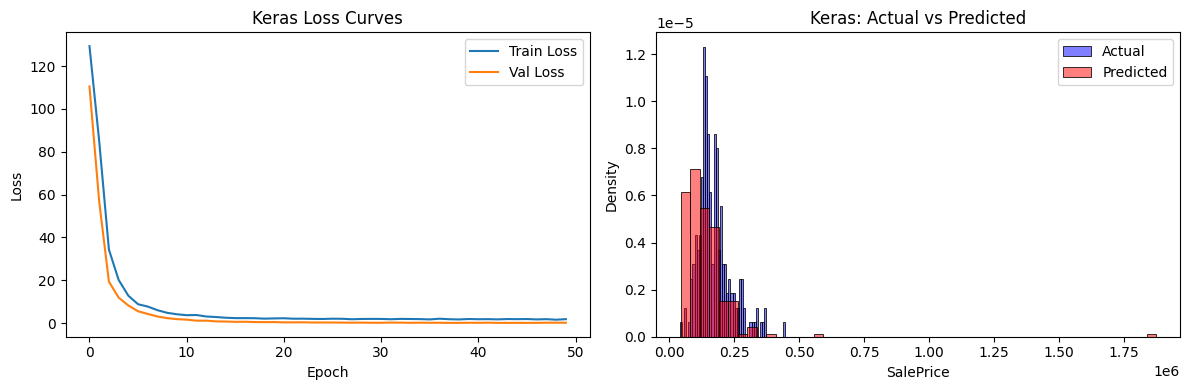

In [8]:
y_val_pred_log_keras = model_keras.predict(X_val_scaled).flatten()
y_val_pred_keras = np.exp(y_val_pred_log_keras)
y_val_actual_keras = np.exp(y_val)

rmse_keras = np.sqrt(mean_squared_error(y_val_actual_keras, y_val_pred_keras))
print('Keras Validation RMSE:', rmse_keras)

# Plot Keras loss + hist
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_keras.history['loss'], label='Train Loss')
plt.plot(history_keras.history['val_loss'], label='Val Loss')
plt.title('Keras Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.5, stat='density', label='Predicted')
plt.title('Keras: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### Keras: Save Test Predictions

In [9]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)

test_preds_log_keras = model_keras.predict(test_scaled).flatten()
test_preds_keras = np.exp(test_preds_log_keras)

predictions_keras = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_keras})
predictions_keras.to_csv('predictions_keras_KL_v4.csv', index=False)
print('Keras predictions saved to predictions_keras_KL_v4.csv')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Keras predictions saved to predictions_keras_KL_v4.csv


/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 3. PyTorch Implementation
Same architecture, alpha=0.001.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class HousePriceNetTorch(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNetTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def soft_histogram_torch_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = torch.cat([y_true, y_pred], dim=0)
    min_val = torch.min(combined)
    max_val = torch.max(combined)
    bin_centers = torch.linspace(min_val, max_val, steps=num_bins, device=y_true.device)

    def compute_hist(vals):
        vals = vals.view(-1,1)
        diff = vals - bin_centers.view(1,-1)
        soft_counts = torch.exp(- (diff**2)/(2*sigma**2))
        hist = torch.sum(soft_counts, dim=0)
        hist = hist / torch.sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def combined_loss_torch(y_true, y_pred):
    mse = torch.mean((y_true - y_pred)**2)
    hist_true, hist_pred = soft_histogram_torch_both(y_true, y_pred, 50, 1.0)
    epsilon = 1e-6
    hist_true = torch.clamp(hist_true, min=epsilon, max=1.0)
    hist_pred = torch.clamp(hist_pred, min=epsilon, max=1.0)
    kl = torch.sum(hist_true * torch.log(hist_true / hist_pred))
    alpha = 0.001
    return mse + alpha*kl

model_torch = HousePriceNetTorch(X_train_scaled.shape[1]).to(device)
print(model_torch)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1).to(device)

optimizer_torch = optim.Adam(model_torch.parameters(), lr=1e-3)
train_losses_pt = []
val_losses_pt = []
num_epochs_pt = 50

for epoch in range(num_epochs_pt):
    model_torch.train()
    optimizer_torch.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = combined_loss_torch(y_train_tensor, outputs)
    loss.backward()
    optimizer_torch.step()
    train_losses_pt.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = combined_loss_torch(y_val_tensor, val_outputs)
        val_losses_pt.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_pt}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Using device: cpu
HousePriceNetTorch(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch 10/50, Train Loss: 123.4979, Val Loss: 121.2231
Epoch 20/50, Train Loss: 100.4267, Val Loss: 98.2457
Epoch 30/50, Train Loss: 71.9335, Val Loss: 70.3665
Epoch 40/50, Train Loss: 43.9772, Val Loss: 42.6531
Epoch 50/50, Train Loss: 23.5858, Val Loss: 22.8432


### PyTorch Evaluation
Separate loss curves and hist plot.

PyTorch Validation RMSE: 43272982.104576245


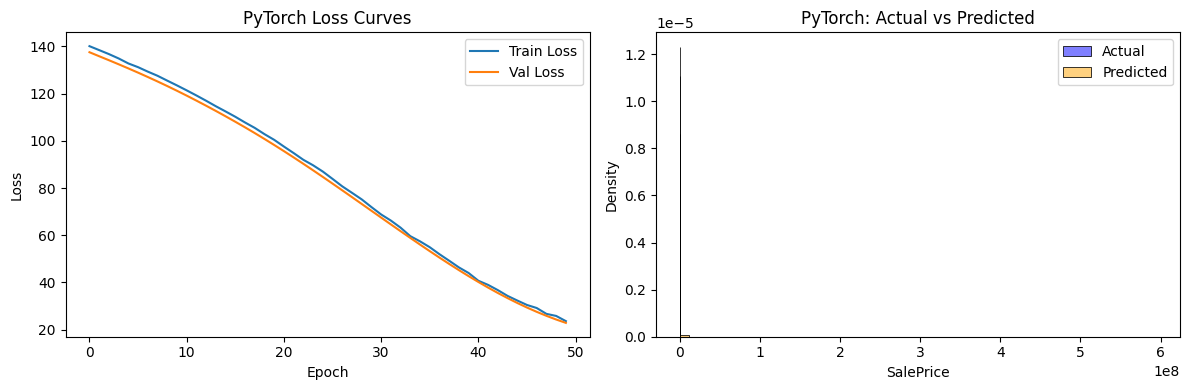

In [11]:
model_torch.eval()
with torch.no_grad():
    val_preds_pt_log = model_torch(X_val_tensor).cpu().numpy().flatten()
val_preds_pt = np.exp(val_preds_pt_log)
y_val_actual_pt = np.exp(y_val_tensor.cpu().numpy().flatten())
rmse_torch = np.sqrt(mean_squared_error(y_val_actual_pt, val_preds_pt))
print('PyTorch Validation RMSE:', rmse_torch)

# Plot PyTorch
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses_pt, label='Train Loss')
plt.plot(val_losses_pt, label='Val Loss')
plt.title('PyTorch Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_pt, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.5, stat='density', label='Predicted')
plt.title('PyTorch: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### PyTorch: Save Test Predictions

In [12]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

model_torch.eval()
with torch.no_grad():
    test_preds_pt_log = model_torch(test_tensor).cpu().numpy().flatten()
test_preds_pt = np.exp(test_preds_pt_log)

predictions_torch = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_pt})
predictions_torch.to_csv('predictions_pytorch_KL_v4.csv', index=False)
print('PyTorch predictions saved to predictions_pytorch_KL_v4.csv')

PyTorch predictions saved to predictions_pytorch_KL_v4.csv


/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 4. JAX (Flax & Optax)
Two hidden layers, alpha=0.001.

In [13]:
class HousePriceNetJAX(nn_flax.Module):
    dropout_rate: float = 0.2

    @nn_flax.compact
    def __call__(self, x, training):
        x = nn_flax.Dense(128)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(64)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(1)(x)
        return x

model_jax = HousePriceNetJAX()
rng_jax = jax.random.PRNGKey(0)
dummy_input = jnp.ones((X_train_scaled.shape[0], X_train_scaled.shape[1]))
params_jax = model_jax.init(rng_jax, dummy_input, training=True)['params']
print('JAX model params initialized.')

class TrainState(train_state.TrainState):
    pass

def soft_histogram_jax_both(y_true, y_pred, num_bins=50, sigma=1.0):
    combined = jnp.concatenate([y_true, y_pred])
    min_val = jnp.min(combined)
    max_val = jnp.max(combined)
    bin_centers = jnp.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        vals = vals.reshape(-1,1)
        diff = vals - bin_centers
        soft_counts = jnp.exp(- (diff**2)/(2*sigma**2))
        hist = jnp.sum(soft_counts, axis=0)
        hist = hist / jnp.sum(hist)
        return hist

    return compute_hist(y_true), compute_hist(y_pred)

def combined_loss_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    mse = jnp.mean((preds - targets)**2)
    hist_true, hist_pred = soft_histogram_jax_both(jnp.ravel(targets), jnp.ravel(preds), 50, 1.0)
    epsilon = 1e-6
    hist_true = jnp.clip(hist_true, epsilon, 1.0)
    hist_pred = jnp.clip(hist_pred, epsilon, 1.0)
    kl = jnp.sum(hist_true * jnp.log(hist_true/hist_pred))
    alpha = 0.001
    return mse + alpha*kl

tx = optax.adam(learning_rate=1e-3)
state_jax = TrainState.create(apply_fn=model_jax.apply, params=params_jax, tx=tx)
print('JAX train state created.')

@jax.jit
def train_step_jax(state, batch, rng):
    def loss_fn(params):
        return combined_loss_jax(params, batch, rng, True)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step_jax(params, batch, rng):
    return combined_loss_jax(params, batch, rng, False)

X_train_jax = jnp.array(X_train_scaled)
y_train_jax = jnp.array(y_train.values).reshape(-1,1)
X_val_jax = jnp.array(X_val_scaled)
y_val_jax = jnp.array(y_val.values).reshape(-1,1)

train_losses_jax = []
val_losses_jax = []
num_epochs_jax = 50

for epoch in range(num_epochs_jax):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (X_train_jax, y_train_jax)
    state_jax, loss = train_step_jax(state_jax, batch_train, step_rng)
    train_losses_jax.append(loss.item())

    batch_val = (X_val_jax, y_val_jax)
    val_loss = eval_step_jax(state_jax.params, batch_val, step_rng)
    val_losses_jax.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_jax}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

JAX model params initialized.
JAX train state created.
Epoch 10/50, Train Loss: 108.8848, Val Loss: 104.7502
Epoch 20/50, Train Loss: 74.2117, Val Loss: 72.7766
Epoch 30/50, Train Loss: 48.3148, Val Loss: 47.4219
Epoch 40/50, Train Loss: 36.4610, Val Loss: 35.9227
Epoch 50/50, Train Loss: 34.4891, Val Loss: 31.4436


### JAX Evaluation
Separate loss curves and hist plot.

JAX Validation RMSE: 26872678892.90248


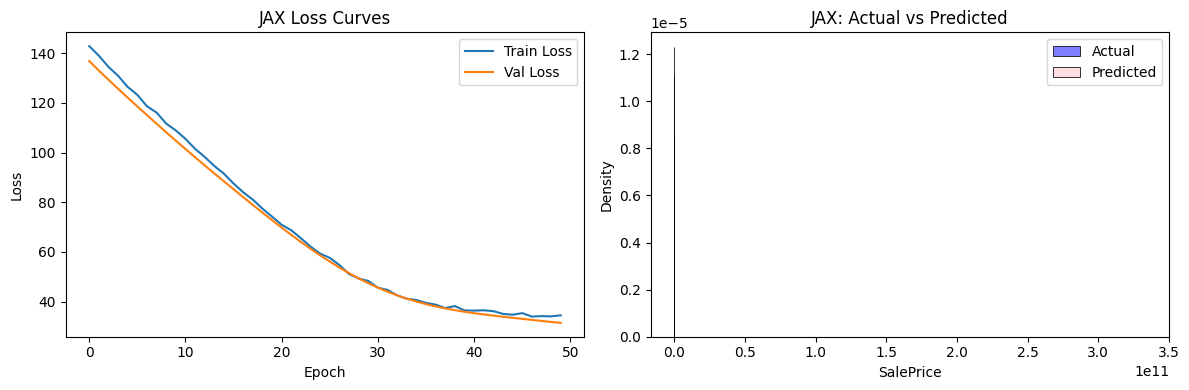

In [14]:
preds_val_log_jax = model_jax.apply({'params': state_jax.params}, X_val_jax, training=False, rngs={'dropout': rng_jax})
preds_val_log_jax = np.array(preds_val_log_jax).flatten()
val_preds_jax = np.exp(preds_val_log_jax)
y_val_actual_jax = np.exp(y_val_jax.flatten())

rmse_jax = np.sqrt(mean_squared_error(y_val_actual_jax, val_preds_jax))
print('JAX Validation RMSE:', rmse_jax)

# Plot JAX
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses_jax, label='Train Loss')
plt.plot(val_losses_jax, label='Val Loss')
plt.title('JAX Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(y_val_actual_jax, bins=50, color='blue', alpha=0.5, stat='density', label='Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.5, stat='density', label='Predicted')
plt.title('JAX: Actual vs Predicted')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### JAX: Save Test Predictions

In [15]:
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_jax = jnp.array(test_scaled)

test_preds_log_jax = model_jax.apply({'params': state_jax.params}, test_jax, training=False, rngs={'dropout': rng_jax})
test_preds_log_jax = np.array(test_preds_log_jax).flatten()
test_preds_jax = np.exp(test_preds_log_jax)

predictions_jax = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_jax})
predictions_jax.to_csv('predictions_jax_KL_v4.csv', index=False)
print('JAX predictions saved to predictions_jax_KL_v4.csv')

/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_6843/4254733079.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

JAX predictions saved to predictions_jax_KL_v4.csv


## 5. Compare RMSE

In [16]:
print('Keras RMSE:', rmse_keras)
print('PyTorch RMSE:', rmse_torch)
print('JAX RMSE:', rmse_jax)

Keras RMSE: 130116.22924404392
PyTorch RMSE: 43272982.104576245
JAX RMSE: 26872678892.90248


Keras RMSE: 130116.22924404392
PyTorch RMSE: 43272982.104576245
JAX RMSE: 26872678892.90248


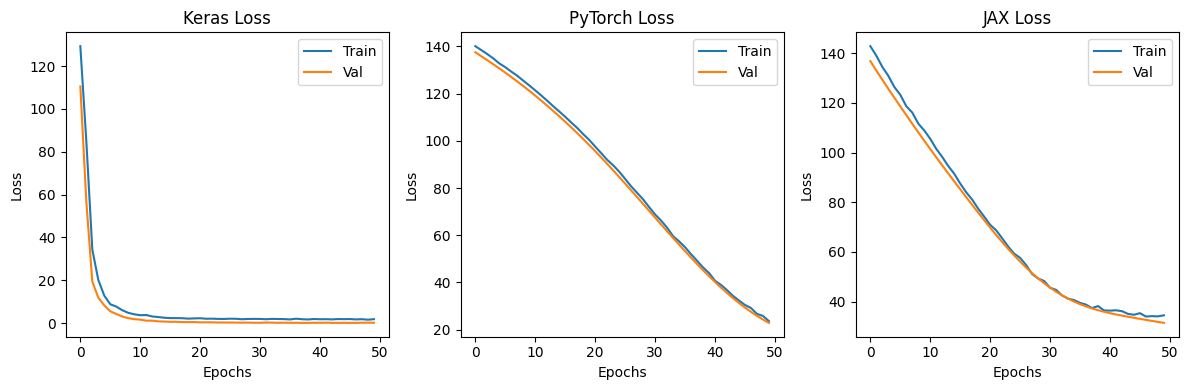

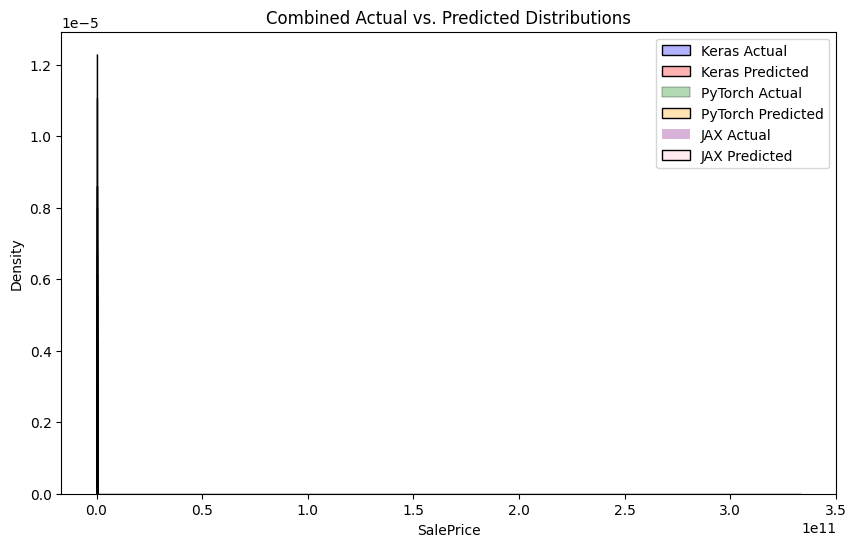

In [19]:
# Print summary RMSE values
print("Keras RMSE:", rmse_keras)
print("PyTorch RMSE:", rmse_torch)
print("JAX RMSE:", rmse_jax)

# Plot combined loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(history_keras.history['loss'], label='Train')
plt.plot(history_keras.history['val_loss'], label='Val')
plt.title('Keras Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_losses_pt, label='Train')
plt.plot(val_losses_pt, label='Val')
plt.title('PyTorch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_losses_jax, label='Train')
plt.plot(val_losses_jax, label='Val')
plt.title('JAX Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual_keras, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred_keras, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.legend()
plt.show()